## In this assignment students need to predict whether a person makes over 50K per year or not from classic adult dataset using XGBoost.

### loading libraries

In [1]:
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.metrics import accuracy_score
import xgboost as xg

### loading dataset

In [2]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

In [3]:
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)

In [4]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [4]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
'native_country', 'wage_class']

In [5]:
train_set.columns = col_labels

In [6]:
test_set.columns = col_labels

In [7]:
train_set.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [31]:
test_set.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.


In [8]:
#help(XGBClassifier())
train_set.shape

(32561, 15)

In [9]:
train_set.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education_num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital_gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital_loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours_per_week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


In [10]:
train_set['wage_class'] = train_set.wage_class.map({' >50K' : 1, ' <=50K' : 0})

Text(0, 0.5, 'frequency')

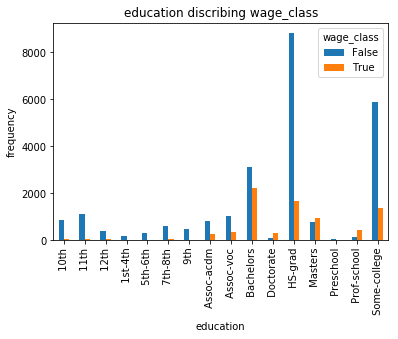

In [11]:
pd.crosstab(train_set.education, train_set.wage_class.astype(bool)).plot(kind='bar')
plt.title('education discribing wage_class')
plt.xlabel('education')
plt.ylabel('frequency')

In [12]:
# create dataframes with an intercept column and dummy variables
y_train, X_train = dmatrices('wage_class ~ age+fnlwgt+education_num+capital_gain+capital_loss+hours_per_week+C(education)+C(occupation)+\
                 C(workclass)', train_set, return_type="dataframe")

In [13]:
x_col = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']

In [14]:
X_new_train = X_train[x_col]

In [44]:
## Model fitting

In [15]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 50,
    'learning_rate': 1, #1.0
    'silent': 1, #1.0
    'n_estimators': 120
}

In [16]:
xgb = XGBClassifier(**params).fit(X_new_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
xgb.score(X_new_train, y_train)

0.9987715365007217

## Evalution of model

In [18]:
y_pred = xgb.predict(X_new_train)

In [19]:
accuracy_score(y_train, y_pred)

0.9987715365007217

In [28]:
## predicting model on test data

In [35]:
test_set['wage_class'] = test_set.wage_class.map({' >50K.' : 1, ' <=50K.' : 0})

In [55]:
y_test_target = test_set['wage_class']

In [30]:
x_col = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']

In [62]:
X_test_new = test_set[x_col]

In [64]:
y_test_pred = xgb.predict(X_test_new)

In [66]:
accuracy_score(y_test_target, y_test_pred)

0.8139549167741539

In [70]:
dtrain = xg.DMatrix(X_new_train)

In [71]:
list(zip(dtrain.feature_names, xgb.feature_importances_))

[('age', 0.032455206),
 ('fnlwgt', 0.019191869),
 ('education_num', 0.058864787),
 ('capital_gain', 0.64596933),
 ('capital_loss', 0.20969477),
 ('hours_per_week', 0.033824075)]

## Capital_gain feature of train data has more impoartance with 64% score

In [69]:
dtest = xg.DMatrix(X_test_new)

In [72]:
list(zip(dtest.feature_names, xgb.feature_importances_))

[('age', 0.032455206),
 ('fnlwgt', 0.019191869),
 ('education_num', 0.058864787),
 ('capital_gain', 0.64596933),
 ('capital_loss', 0.20969477),
 ('hours_per_week', 0.033824075)]

In [73]:
## Capital_gain feature of test data has more impoartance with 64% score